### XII. Replay pairwise comparison

In [1]:
%reload_ext autoreload
%autoreload 2

In [15]:
import os
import pickle
import spyglass as nd
import pandas as pd
import statsmodels.api as sm
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import logging
import multiprocessing

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

from spyglass.common import (Session, IntervalList,IntervalPositionInfo,
                             LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common.common_interval import _intersection

from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection


# Here are the analysis tables specific to Shijie Gu
from spyglass.shijiegu.Analysis_SGU import (TrialChoice,
                                            TrialChoiceReplay,
                                            TrialChoiceRemoteReplay,
                                            RippleTimes,
                                            Decode,
                                            TrialChoiceReplayTransition,
                                            get_linearization_map,
                                            find_ripple_times,classify_ripples,classify_ripple_content)
from spyglass.shijiegu.PastFuture_Replay import (replay_in_categories,find_distinct_subset,proportion,
                                                 unravel_replay,count_replay_by_category,category_day)

In [3]:
#datafolder='/stelmo/shijie/recording_pilot/molly/plot/'
datafolder='/cumulus/shijie/recording_pilot/eliot/plot/'

In [4]:
pd.set_option('display.max_rows', None)

In [5]:
T=pd.DataFrame((TrialChoiceReplay() & {'nwb_file_name':'eliot20221016_.nwb',
                                       'epoch':8}).fetch1('choice_reward_replay'))

In [7]:
T

,timestamp_H,Home,timestamp_O,OuterWellIndex,rewardNum,ripple_H,ripple_O,replay_H,ripple_peak_H,replay_O,ripple_peak_O,current,future_H,future_O,past,past_reward
1,1.665960e+09,1.0,1.665960e+09,4.0,1.0,"[[[1665960472.3327117, 1665960472.3887117]], [...","[[[1665960489.1487033, 1665960489.2387033]], [...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...",[],"[[4], [4], [4]]",[],4.0,4.0,2.0,NaN,NaN
2,1.665961e+09,1.0,1.665961e+09,2.0,1.0,"[[[1665960502.1666968, 1665960502.3486967]], [...","[[[1665960522.7886863, 1665960522.8526862]]]","[[0], [3.0, nan], [0], [0], [0], [nan, 0.0], [...",[],[[2]],[],2.0,2.0,3.0,4.0,NaN
3,1.665961e+09,1.0,1.665961e+09,3.0,2.0,"[[[1665960531.086682, 1665960531.1386821]], [[...","[[[1665960558.978668, 1665960559.218668]], [[1...","[[0], [0], [0], [0.0, nan], [nan], [4.0, nan, ...",[],"[[3], [3], [3], [3], [3], [3]]",[],3.0,3.0,1.0,2.0,NaN
4,1.665961e+09,1.0,1.665961e+09,1.0,1.0,"[[[1665960574.83666, 1665960574.9686599]], [[1...","[[[1665960593.5166507, 1665960593.7186506]], [...","[[0], [0], [2], [0], [0], [0], [0], [4.0, nan]...",[],"[[1], [1], [1], [1], [1]]",[],1.0,1.0,4.0,3.0,3.0
5,1.665961e+09,1.0,1.665961e+09,4.0,2.0,"[[[1665960607.6626434, 1665960607.6906433], [1...","[[[1665960626.454634, 1665960626.516634]], [[1...","[[0.0, 5.0, nan, 5.0, nan, 0.0], [0], [0], [0....",[],"[[4], [4], [4], [nan], [4], [nan, 4.0], [4], [...",[],4.0,4.0,2.0,1.0,3.0
6,1.665961e+09,1.0,1.665961e+09,2.0,2.0,"[[[1665960649.7286222, 1665960649.816622]], [[...","[[[1665960661.0966165, 1665960661.1406164]]]","[[2], [0], [0], [0], [0], [0], [0]]",[],[[2]],[],2.0,2.0,3.0,4.0,4.0
7,1.665961e+09,1.0,1.665961e+09,3.0,1.0,"[[[1665960671.3366113, 1665960671.4466112]], [...","[[[1665960683.916605, 1665960683.992605]], [[1...","[[0], [nan]]",[],"[[3], [3]]",[],3.0,3.0,1.0,2.0,2.0
8,1.665961e+09,1.0,1.665961e+09,1.0,2.0,"[[[1665960693.4686, 1665960693.5586], [1665960...","[[[1665960707.0745933, 1665960707.308593]], [[...","[[1.0, 2.0, nan], [0], [0], [nan], [0], [0], [0]]",[],"[[1], [1], [3], [1], [1], [1], [1.0, 5.0, nan]...",[],1.0,1.0,4.0,3.0,2.0
9,1.665961e+09,1.0,1.665961e+09,4.0,1.0,"[[[1665960738.7285771, 1665960738.7925773]], [...","[[[1665960750.4805713, 1665960750.6085713]]]","[[0], [0, 0], [0, 5], [5.0, nan]]",[],[[4]],[],4.0,4.0,2.0,1.0,1.0
10,1.665961e+09,1.0,1.665961e+09,2.0,1.0,"[[[1665960759.3885667, 1665960759.4605668]], [...","[[[1665960768.4545622, 1665960768.5325623]]]","[[0], [0]]",[],[[2]],[],2.0,2.0,3.0,4.0,1.0


### Plot all inter replay interval

In [6]:
'''
nwb_copy_file_names=['molly20220415_.nwb','molly20220416_.nwb',
                     'molly20220417_.nwb','molly20220418_.nwb',
                     'molly20220419_.nwb','molly20220420_.nwb']


nwb_copy_file_names=['eliot20221016_.nwb','eliot20221017_.nwb',
       'eliot20221018_.nwb','eliot20221019_.nwb',
       'eliot20221020_.nwb','eliot20221021_.nwb',
       'eliot20221022_.nwb']
'''
nwb_copy_file_names=['eliot20221020_.nwb','eliot20221021_.nwb',
       'eliot20221022_.nwb']

time_diff_all_inclusive=[]
time_diff_all_arm=[]

In [8]:
for nwb_copy_file_name in nwb_copy_file_names:
    all_epochs=list((TrialChoice() & {'nwb_file_name':nwb_copy_file_name}).fetch('epoch'))
    for e in all_epochs:
        T=pd.DataFrame((TrialChoiceReplay() & {'nwb_file_name':nwb_copy_file_name,
                                   'epoch':e}).fetch1('choice_reward_replay'))
        transitions_all=np.zeros((6,6))
        T_transition=T.copy()
        T_transition.insert(4,'replayed_transitions',[[] for i in range(len(T))]) #hold replayed transitions

        for t in T.index:
            if len(T.loc[t,'ripple_H'])==0:
                continue
            ripple_times=np.concatenate(unravel_replay([T.loc[t,'ripple_H']]))

            # all time between ripples
            time_diff_inclusive=np.diff(ripple_times.reshape((1,-1)).ravel())[1::2]
            if len(time_diff_inclusive)>0:
                time_diff_all_inclusive.append(time_diff_inclusive)

            arms=np.concatenate(unravel_replay([T.loc[t,'replay_H']]))

            # get rid of home and center platform
            arm_ind=~np.isin(arms,[0,5,np.nan])

            arms=arms[arm_ind]
            ripple_times=ripple_times[arm_ind]

            # get rid of nans
            notnan_ind=~np.isnan(arms)
            arms=arms[notnan_ind]
            ripple_times=ripple_times[notnan_ind]

            time_diff=np.diff(ripple_times.reshape((1,-1)).ravel())[1::2]
            if len(time_diff)>0:
                time_diff_all_arm.append(time_diff)

335


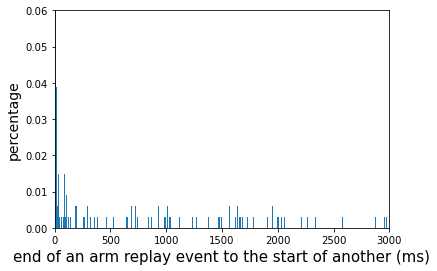

In [9]:
data=np.concatenate(time_diff_all_arm)*1000
print(len(data))
plt.hist(data,bins=5000,
        weights=np.ones(len(data)) / len(data));
ax=plt.gca()
ax.set_xlim([0,3000])
ax.set_ylim([0,0.06])
ax.set_xlabel('end of an arm replay event to the start of another (ms)',fontsize=15)
ax.set_ylabel('percentage',fontsize=14)

plt.savefig(os.path.join(datafolder,'arm replay interval large.pdf'),dpi=300)

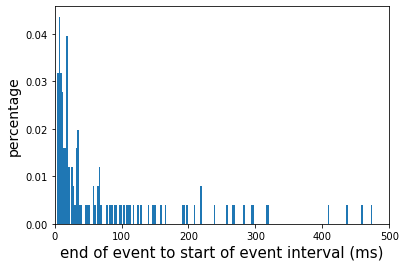

In [76]:
plt.hist(np.concatenate(time_diff_all_arm)*1000,bins=8000,
        weights=np.ones(len(data)) / len(data));
ax=plt.gca()
ax.set_xlim([0,500])
ax.set_xlabel('end of event to start of event interval (ms)',fontsize=15)
ax.set_ylabel('percentage',fontsize=14)

plt.savefig(os.path.join(datafolder,'arm replay interval zoomin.pdf'),dpi=300)

### Find all transitions: data goes into ```TrialChoiceReplayTransition()```

In [10]:
def merge_overlapping_ranges(ranges):
    '''
    return interals and indices of intervals that got merged
    >>> list(merge_overlapping_ranges([(3.1, 5.3), (4.2, 7.5), (10, 11)]))
    [(3.1, 7.5, 0, 1),(10,11, 2, 2)]
    '''
    
    ranges =sorted(ranges)
    if len(ranges)==0:
        return []
    current_start, current_stop=ranges[0]
    previous_j=0
    for j in range(len(ranges)):
        start, stop=ranges[j]
        if start>current_stop: 
            # Gap between segments: output current segment and start a new
            # one.
            yield current_start, current_stop, previous_j,j-1
            current_start, current_stop = start, stop
            previous_j = j
        else:
            # Segments adjacent or overlapping: merge.
            current_stop = max(current_stop, stop)
    yield current_start, current_stop, previous_j, len(ranges)-1

In [11]:
def remove_adjacent(nums):
    i = 1
    while i < len(nums):    
        if nums[i] == nums[i-1]:
            nums.pop(i)
            i -= 1  
        i += 1
    return nums

In [21]:
nwb_copy_file_name='eliot20221019_.nwb'

In [22]:
TrialChoiceRemoteReplay() & {'nwb_file_name':'eliot20221019_.nwb'}

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),"epoch_name session name, get from IntervalList","choice_reward_replay pandas dataframe, choice, reward, remote time, replays"


In [13]:
all_epochs=list((TrialChoice() & {'nwb_file_name':nwb_copy_file_name}).fetch('epoch'))
for e in all_epochs:
    try:
        T=pd.DataFrame((TrialChoiceRemoteReplay() & {'nwb_file_name':nwb_copy_file_name,
                                   'epoch':e}).fetch1('choice_reward_replay'))
    except:
        print(f'likely no data for {nwb_copy_file_name} epoch {e}')
        continue
    
    transitions_all=np.zeros((6,6))
    T_transition=T.copy()
    T_transition.insert(4,'replayed_transitions',[[] for i in range(len(T))]) #hold replayed transitions

    for t in T.index:
        arms=T.loc[t,'replay_H'].copy()
        #arms=np.concatenate(unravel_replay([T.loc[t,'replay_H']]))
        if len(arms)==0:
            continue
        replays_ind=[i for i in range(len(arms)) if len(arms[i])>0]
        #ripple_times=np.concatenate(unravel_replay([T.loc[t,'ripple_H']]))
        ripple_times=T.loc[t,'remote_H'].copy()
        ripple_times=ripple_times[replays_ind]
        arms=[arms[i] for i in replays_ind]
        
        if len(ripple_times)==0:
            continue
        
        ripple_times[:,0]=ripple_times[:,0]-0.1
        ripple_times[:,1]=ripple_times[:,1]+0.1
        
        ripple_times_list=[list(a) for a in ripple_times]
        ripple_bouts=list(merge_overlapping_ranges(ripple_times_list))
        for bout in ripple_bouts:
            arms_bout = np.concatenate([arms[i] 
                                        for i in np.arange(int(bout[2]),int(bout[3])+1)])
            #arms_bout=arms[np.arange(int(bout[2]),int(bout[3])+1)]
        
#         # all time between ripples
#         time_diff_inclusive=np.diff(ripple_times.reshape((1,-1)).ravel())[1::2]
#         if len(time_diff_inclusive)>0:
#             time_diff_all_inclusive.append(time_diff_inclusive)

#         arms=np.concatenate(unravel_replay([T.loc[t,'replay_H']]))
        
            # get rid of home and center platform
            arm_ind=~np.isin(arms_bout,[0,5])

            arms_bout=arms_bout[arm_ind]
#        ripple_times=ripple_times[arm_ind]
        
            # get rid of nans
            notnan_ind=~np.isnan(arms_bout)
            arms_bout=arms_bout[notnan_ind]

            if len(arms_bout)==0:
                continue
            if len(arms_bout)>1:
                # get rid of adjacent duplicates
                arms_bout=np.array(remove_adjacent(list(arms_bout)))
                for m in range(len(arms_bout)-1):
                    i=int(arms_bout[m])
                    j=int(arms_bout[m+1])
                    if i!=j:
                        transitions_all[i,j]+=1
                        T_transition.at[t,'replayed_transitions'].append((i,j))
            else:
                transitions_all[int(arms_bout[0]),int(arms_bout[0])]+=1
#        ripple_times=ripple_times[notnan_ind]

#         time_diff=np.diff(ripple_times.reshape((1,-1)).ravel())[1::2]
#         if len(time_diff)>0:
#             time_diff_all_arm.append(time_diff)
        
#         pairs_arms_ind=[]
#         for m in np.argwhere(time_diff<=0.2).ravel(): #transition index
#             i=arms[m]
#             j=arms[m+1]
#             if i!=j:
#                 i=int(i)
#                 j=int(j)
#                 T_transition.at[t,'replayed_transitions'].append((i,j))
#                 transitions_all[i,j]+=1
#             pairs_arms_ind.append(m)
#             pairs_arms_ind.append(m+1)
            
#         singleton_arms=arms[np.setdiff1d(np.arange(len(arms)),np.array(pairs_arms_ind))]
#         for m in singleton_arms:
#             transitions_all[int(m),int(m)]+=1
    transitions_all=transitions_all[1:-1,:]
    transitions_all=transitions_all[:,1:-1]
    
    # insert to Spyglass
    key={'nwb_file_name':nwb_copy_file_name,
         'epoch':e,
         'choice_reward_replay_transition':T_transition.to_dict(),
         'transitions':transitions_all}
    TrialChoiceReplayTransition().make(key,replace=True)
    print(transitions_all)

likely no data for eliot20221019_.nwb epoch 2
likely no data for eliot20221019_.nwb epoch 4
likely no data for eliot20221019_.nwb epoch 6
likely no data for eliot20221019_.nwb epoch 8
likely no data for eliot20221019_.nwb epoch 10


### Test load data

In [339]:
nwb_copy_file_name='molly20220420_.nwb'
epoch_num=8

In [357]:
transitions_all=(TrialChoiceReplayTransition() & 
                 {'nwb_file_name':nwb_copy_file_name,
                  'epoch':epoch_num}).fetch1('transitions')
transitions_all

array([[16.,  1.,  0.,  4.],
       [ 2., 15.,  0.,  2.],
       [ 0.,  0.,  8.,  1.],
       [ 0.,  0.,  0., 21.]])

In [340]:
transitions_all=(TrialChoiceReplayTransition() & 
                 {'nwb_file_name':nwb_copy_file_name,
                  'epoch':epoch_num}).fetch1('transitions')
transitions_all

array([[16.,  1.,  0.,  4.],
       [ 2., 15.,  0.,  2.],
       [ 0.,  0.,  8.,  1.],
       [ 0.,  0.,  0., 21.]])

In [334]:
T=pd.DataFrame((TrialChoiceReplayTransition() &
                {'nwb_file_name':nwb_copy_file_name,
                 'epoch':epoch_num}).fetch1('choice_reward_replay_transition'))
T

,timestamp_H,Home,timestamp_O,OuterWellIndex,replayed_transitions,rewardNum,ripple_H,ripple_O,replay_H,ripple_peak_H,replay_O,ripple_peak_O
1,1.650320e+09,1.0,1.650320e+09,3.0,[],2.0,"[[[1650320152.3434083, 1650320152.4214084]], [...","[[[1650320173.0753992, 1650320173.1273992]], [...","[[nan], [0.0, nan, 4.0]]",[],"[[3], [3], [3], [3], [3]]",[]
4,1.650320e+09,1.0,1.650320e+09,3.0,[],1.0,[],"[[[1650320240.4073696, 1650320240.5133696]]]",[],[],[[3]],[]
5,1.650320e+09,1.0,1.650320e+09,2.0,[],2.0,"[[[1650320244.9893675, 1650320245.1773674]], [...","[[[1650320254.1153636, 1650320254.1853635]], [...","[[0], [0], [0, 1], [5]]",[],"[[2], [2], [2], [2], [2], [2], [2], [2], [2], ...",[]
6,1.650320e+09,1.0,1.650320e+09,4.0,[],1.0,"[[[1650320267.7833576, 1650320267.9653575]], [...","[[[1650320277.8253531, 1650320277.889353]]]","[[0], [0], [0], [0], [0], [0], [0]]",[],[[4]],[]
7,1.650320e+09,1.0,1.650320e+09,1.0,[],2.0,"[[[1650320284.92535, 1650320284.97135]], [[165...","[[[1650320293.2613463, 1650320293.3133464]], [...","[[0], [0], [0]]",[],"[[1], [1], [1], [1], [1], [1]]",[]
8,1.650320e+09,1.0,1.650320e+09,3.0,[],2.0,"[[[1650320305.7613409, 1650320305.9533408]], [...","[[[1650320316.297336, 1650320316.343336]], [[1...","[[0], [0], [2]]",[],"[[3], [3], [3], [3]]",[]
9,1.650320e+09,1.0,1.650320e+09,4.0,[],2.0,"[[[1650320331.0693297, 1650320331.1833296]], [...","[[[1650320377.4033093, 1650320377.4593093]], [...","[[1], [0.0, nan], [0], [0]]",[],"[[4], [4], [4]]",[]
10,1.650320e+09,1.0,1.650320e+09,1.0,[],1.0,"[[[1650320391.2013032, 1650320391.2553031]], [...",[],"[[1], [0], [0], [0], [0], [0]]",[],[],[]
11,1.650320e+09,1.0,1.650320e+09,3.0,[],1.0,"[[[1650320407.6552958, 1650320407.825296]], [[...",[],"[[0], [0]]",[],[],[]
12,1.650320e+09,1.0,1.650320e+09,2.0,[],2.0,"[[[1650320429.1892865, 1650320429.3052864], [1...","[[[1650320439.145282, 1650320439.217282]], [[1...","[[2.0, 2.0, 5.0, nan], [0], [0]]",[],"[[2], [5], [0], [2], [2], [2], [2], [2]]",[]


In [316]:
T.loc[11,:]

timestamp_H                                             1650477700.547073
Home                                                                  1.0
timestamp_O                                             1650477710.329101
OuterWellIndex                                                        4.0
replayed_transitions                                                   []
rewardNum                                                             2.0
ripple_H                [[[1650477700.7430654, 1650477700.8490653]], [...
ripple_O                [[[1650477715.8290586, 1650477715.8790586], [1...
replay_H                  [[0], [0], [0], [nan, 5.0], [5], [0], [0], [0]]
ripple_peak_H                                                          []
replay_O                                 [[4.0, nan, 4.0, nan], [3], [4]]
ripple_peak_O                                                          []
Name: 11, dtype: object

### Plot sequence

In [85]:
seq1=[2,4,1,3];
seq2=[3,4,2,1];
seq3=[1,2,3,4];

rev1=[2,3,1,4];
rev2=[2,4,3,1];
rev3=[1,4,3,2];

seqs=np.vstack((seq1,seq2,seq3,rev1,rev2,rev3))
orders=['seq1','seq2','seq3','rev1','rev2','rev3']

In [86]:
trans_seq={}
for i in range(4):
    for j in range(4):
        if i!=j:
            trans_seq[(i+1,j+1)]=[]
            
for seq_ind in range(np.shape(seqs)[0]):
    seq=seqs[seq_ind]
    for i in range(len(seq)):
        trans_seq[(seq[i],seq[(i+1)%4])].append(seq_ind+1)

In [87]:
trans_seq

{(1, 2): [3, 5],
 (1, 3): [1, 2],
 (1, 4): [4, 6],
 (2, 1): [2, 6],
 (2, 3): [3, 4],
 (2, 4): [1, 5],
 (3, 1): [4, 5],
 (3, 2): [1, 6],
 (3, 4): [2, 3],
 (4, 1): [1, 3],
 (4, 2): [2, 4],
 (4, 3): [5, 6]}

In [397]:
nwb_copy_file_name='molly20220420_.nwb'
epoch_num=8

In [405]:
def find_seq_count_epoch(nwb_copy_file_name,epoch_num):
    transitions_all=(TrialChoiceReplayTransition() & 
                 {'nwb_file_name':nwb_copy_file_name,
                  'epoch':epoch_num}).fetch1('transitions')

    seq_count=np.zeros(6)
    pairs=list(trans_seq.keys())
    for p in pairs:
        c=transitions_all[p[0]-1,p[1]-1]
        seqs=trans_seq[p]
        seq_count[seqs[0]-1]+=c
        seq_count[seqs[1]-1]+=c
        
    return seq_count

In [462]:
seq_count=[]
sum_count=[]
nwb_copy_file_names=['molly20220415_.nwb','molly20220416_.nwb',
                     'molly20220417_.nwb','molly20220418_.nwb',
                     'molly20220419_.nwb','molly20220420_.nwb']

for nwb_copy_file_name in nwb_copy_file_names:
    all_epochs=list((TrialChoiceReplayTransition() & 
                 {'nwb_file_name':nwb_copy_file_name}).fetch('epoch'))

    seq_count_day=np.zeros(6)
    for epoch_num in all_epochs:
        seq_count_epoch=find_seq_count_epoch(nwb_copy_file_name,epoch_num)
        seq_count_day=seq_count_day+seq_count_epoch
    sum_count.append(np.sum(seq_count_day))
    seq_count_day=seq_count_day/np.sum(seq_count_day)
    seq_count.append(seq_count_day)    
seq_count=np.array(seq_count)

Text(0, 0.5, 'occurance rate')

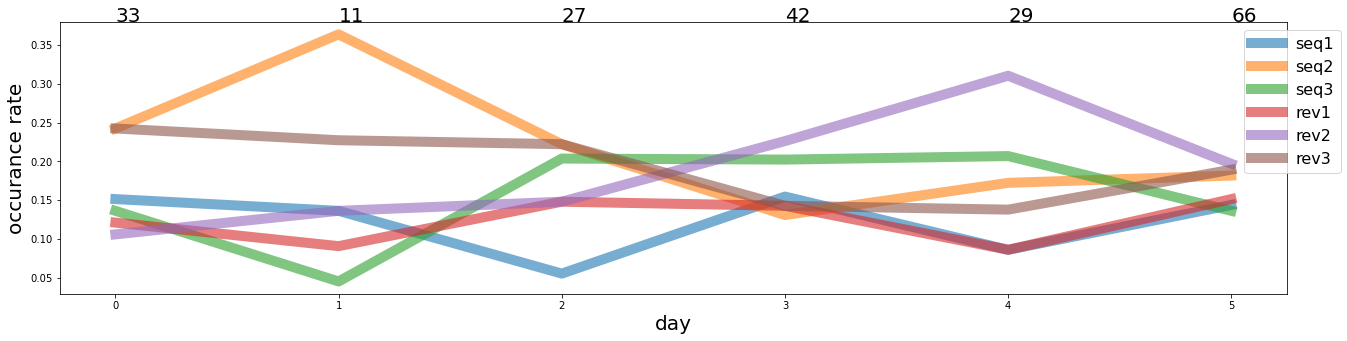

In [470]:
fig,axes=plt.subplots(1,1,figsize=(22, 5))
lines=[]
for i in range(6):
    line1,=plt.plot(seq_count[:,i],color='C'+str(i),alpha=0.6,label=orders[i],linewidth=10)
    lines.append(line1)
y3=axes.get_ylim()
for i in range(6):
    plt.text(i,y3[1],int(sum_count[i]/2),fontsize=20)
axes.legend(handles=lines,fontsize=16,bbox_to_anchor=(1.05, 1))

#axes.set_title('pairwise replays by sequences by day',fontsize=20,)
axes.set_xlabel('day',fontsize=20,)
axes.set_ylabel('occurance rate',fontsize=20,)

In [479]:
seq_count=[]
dates=[]
nwb_copy_file_names=['molly20220415_.nwb','molly20220416_.nwb',
                     'molly20220417_.nwb','molly20220418_.nwb',
                     'molly20220419_.nwb','molly20220420_.nwb']
for nwb_copy_file_name in nwb_copy_file_names:
    all_epochs=list((TrialChoiceReplayTransition() & 
                 {'nwb_file_name':nwb_copy_file_name}).fetch('epoch'))

    seq_count_day=np.zeros(6)
    for epoch_num in all_epochs:
        seq_count_epoch=find_seq_count_epoch(nwb_copy_file_name,epoch_num)
        if np.sum(seq_count_epoch)>14:
            seq_count_epoch=seq_count_epoch/np.sum(seq_count_epoch)
            seq_count.append(seq_count_epoch)
            dates.append(int(nwb_copy_file_name[5:13]))
seq_count=np.array(seq_count)
dates=np.array(dates)

Text(0.5, 0, 'session')

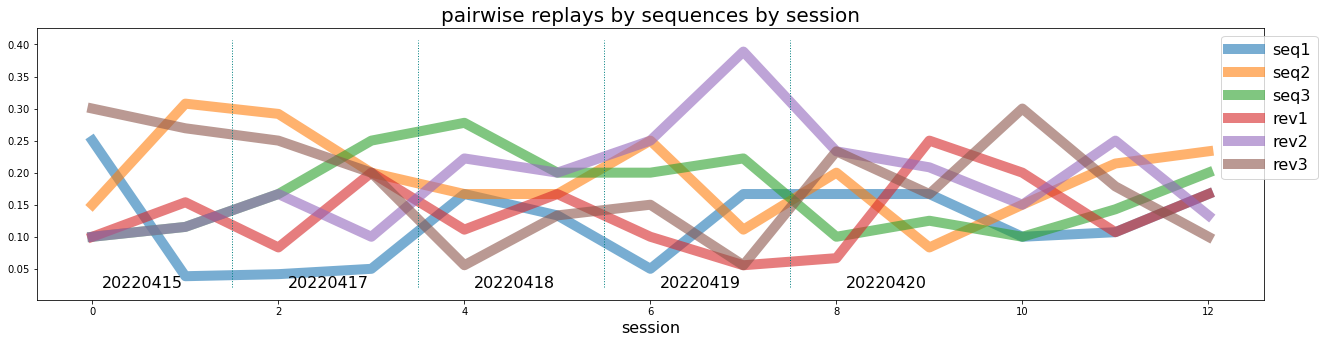

In [480]:
fig,axes=plt.subplots(1,1,figsize=(22, 5))
lines=[]
for i in range(6):
    line1,=plt.plot(seq_count[:,i],alpha=0.6,color='C'+str(i),label=orders[i],linewidth=10)
    lines.append(line1)
    
day_change=np.argwhere(np.diff(dates)).ravel()+1
y3=axes.get_ylim()
axes.text(0.1,y3[0],dates[0],fontsize=16)
for t in day_change:
    axes.plot([t-0.5,t-0.5],y3,':',linewidth=1,color='teal')
    axes.text(t+0.1,y3[0],dates[t],fontsize=16)
    
axes.legend(handles=lines,fontsize=16,bbox_to_anchor=(1.05, 1))
axes.set_title('pairwise replays by sequences by session',fontsize=20,)
axes.set_xlabel('session',fontsize=16,)